In [28]:
import pandas as pd, numpy as np, datetime
import matplotlib.pyplot as plt, seaborn as sns, scikitplot as skplt
from scipy import stats

from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE

from sklearn.model_selection import (
    train_test_split, learning_curve, ShuffleSplit, RandomizedSearchCV,
    cross_val_score, KFold
)

from sklearn.tree import DecisionTreeClassifier, plot_tree
import sklearn.tree as tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV as CCV
import xgboost as xgb

import sklearn.metrics as metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, brier_score_loss,
    roc_curve, auc, make_scorer
)
import torch
import os
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

### Loading Data

In [2]:
# Load the datasets
pokemon = pd.read_csv("pokemon.csv") 
battles = pd.read_csv("combats.csv")

In [3]:
print(battles.head())
print(pokemon.head())

   First_pokemon  Second_pokemon  Winner
0            266             298     298
1            702             701     701
2            191             668     668
3            237             683     683
4            151             231     151
   #           Name Type 1  Type 2  HP  Attack  Defense  Sp. Atk  Sp. Def  \
0  1      Bulbasaur  Grass  Poison  45      49       49       65       65   
1  2        Ivysaur  Grass  Poison  60      62       63       80       80   
2  3       Venusaur  Grass  Poison  80      82       83      100      100   
3  4  Mega Venusaur  Grass  Poison  80     100      123      122      120   
4  5     Charmander   Fire     NaN  39      52       43       60       50   

   Speed  Generation  Legendary  
0     45           1      False  
1     60           1      False  
2     80           1      False  
3     80           1      False  
4     65           1      False  


### Data Exploration

In [4]:
 pokemon.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        799 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


In [5]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pokemon.describe()

,#,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00
mean,400.50,69.26,79.00,73.84,72.82,71.90,68.28,3.32
std,231.08,25.53,32.46,31.18,32.72,27.83,29.06,1.66
min,1.00,1.00,5.00,5.00,10.00,20.00,5.00,1.00
25%,200.75,50.00,55.00,50.00,49.75,50.00,45.00,2.00
50%,400.50,65.00,75.00,70.00,65.00,70.00,65.00,3.00
75%,600.25,80.00,100.00,90.00,95.00,90.00,90.00,5.00
max,800.00,255.00,190.00,230.00,194.00,230.00,180.00,6.00


In [6]:
pokemon.describe(include=['object','category'])

,Name,Type 1,Type 2
count,799,800,414
unique,799,18,18
top,Bulbasaur,Water,Flying
freq,1,112,97


In [7]:
pokicat=pokemon[['#', 'Name', 'Type 1', 'Type 2', 'Generation', 'Legendary']]
pokidigit = pd.merge(
    pokemon,
    pokicat,
    on='#'
).loc[:, ['#', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]

#Normalization
std_stats = pokidigit.set_index('#').apply(
    lambda x: (x - min(x)) /(max(x)-min(x)))
std_stats['strength'] = std_stats.sum(axis='columns')

#top 5 strogest combinations
joined = pd.merge(
    pokicat,
    std_stats,
    on='#'
)

# Group by just the two type columns and compute the mean of strength
means = (
    joined
      .groupby(['Type 1', 'Type 2'])['strength']  
      .mean()
      .reset_index()
)

# Sort and show top 5
top5 = means.sort_values('strength', ascending=False).head(5)
print(top5)


      Type 1  Type 2  strength
70    Ground    Fire      3.60
95   Psychic    Dark      3.22
24    Dragon     Ice      3.18
21    Dragon    Fire      3.16
114    Steel  Dragon      3.15


C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

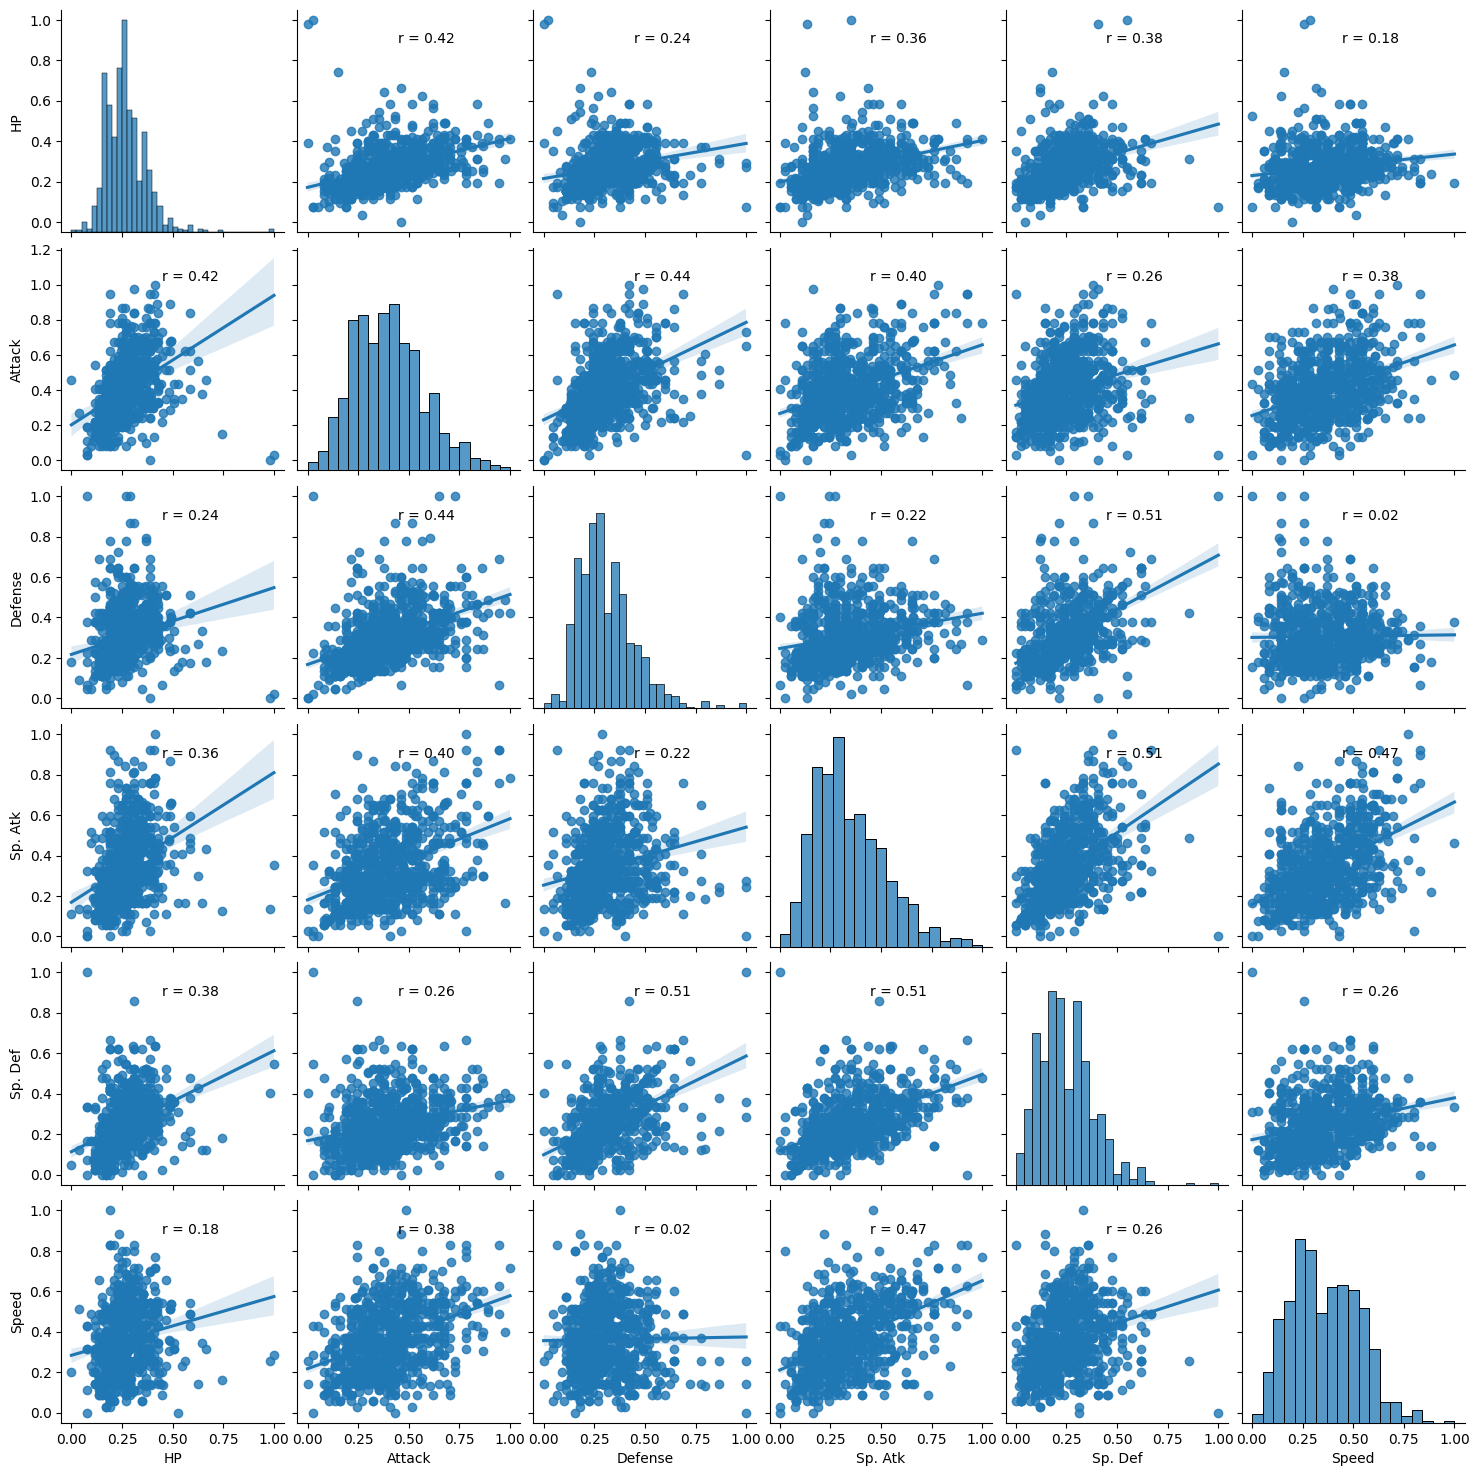

In [8]:
def show_corr(x, y, **kwargs):
    (r, _) = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(
        'r = {:.2f}'.format(r),
        xy=(0.45, 0.85),
        xycoords=ax.transAxes
    )
sns.pairplot(
    data=joined.loc[:, 'HP':'Speed'],
    kind='reg'
).map_offdiag(show_corr);

No high correlation

array([[<Axes: title={'center': 'HP'}>,
        <Axes: title={'center': 'Attack'}>],
       [<Axes: title={'center': 'Defense'}>,
        <Axes: title={'center': 'Sp. Atk'}>],
       [<Axes: title={'center': 'Sp. Def'}>,
        <Axes: title={'center': 'Speed'}>]], dtype=object)

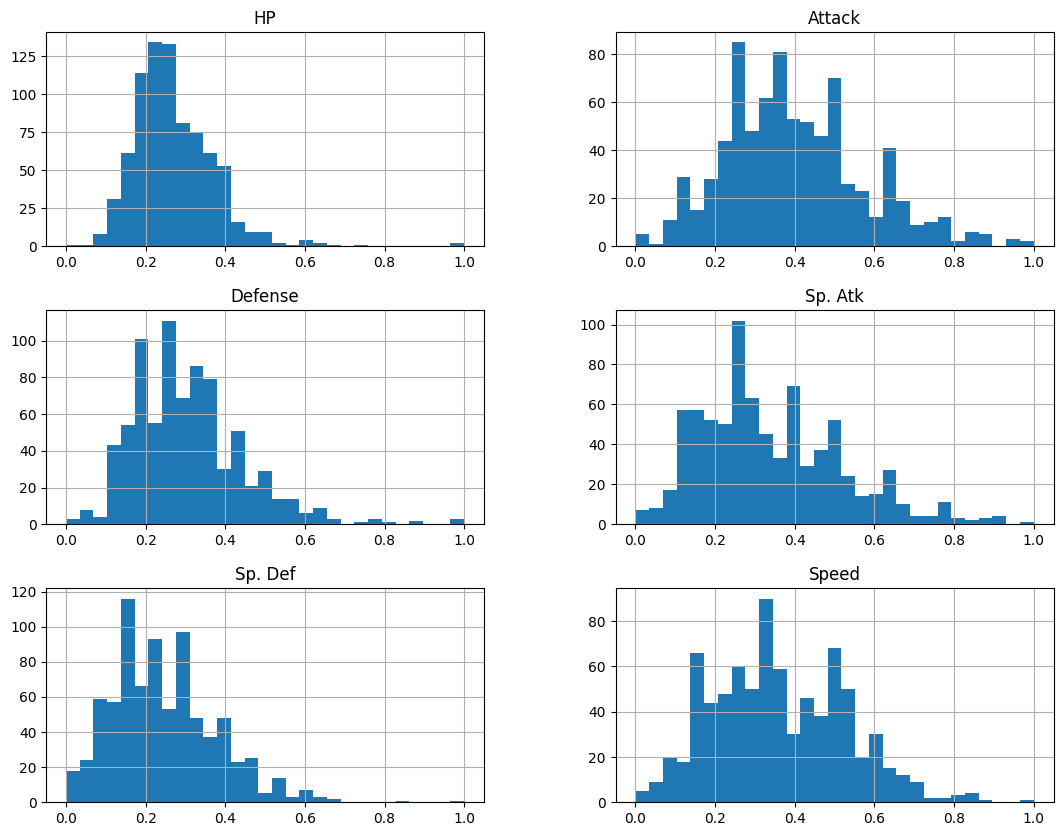

In [9]:
#Histograms for all continous features
%matplotlib inline
joined.hist(column=['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed'], bins=29, figsize=(13,10))


<Axes: >

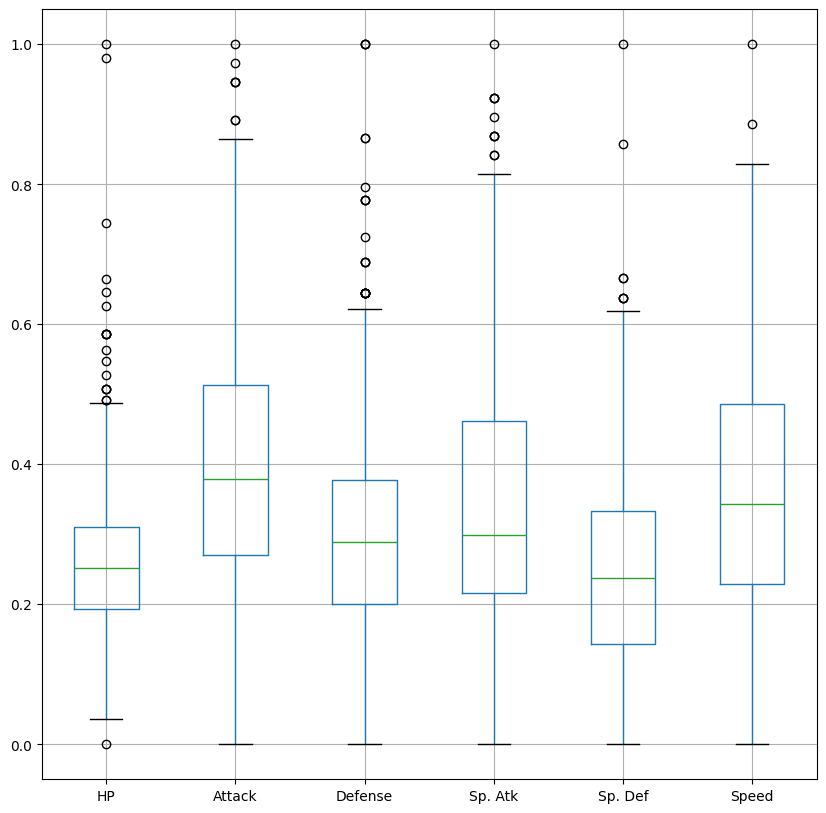

In [10]:
joined.boxplot(['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed'],figsize = (10,10))

In [11]:
name_map = pokemon.set_index('#')['Name']

df = (
    battles
      .drop(columns='First_pokemon')
      .assign(First_pokemon = battles['First_pokemon'].map(name_map))
      .drop(columns='Second_pokemon')
      .assign(Second_pokemon = battles['Second_pokemon'].map(name_map))
      .drop(columns='Winner')
      .assign(Winner = battles['Winner'].map(name_map))
)

df.head()

,First_pokemon,Second_pokemon,Winner
0,Larvitar,Nuzleaf,Nuzleaf
1,Virizion,Terrakion,Terrakion
2,Togetic,Beheeyem,Beheeyem
3,Slugma,Druddigon,Druddigon
4,Omastar,Shuckle,Omastar


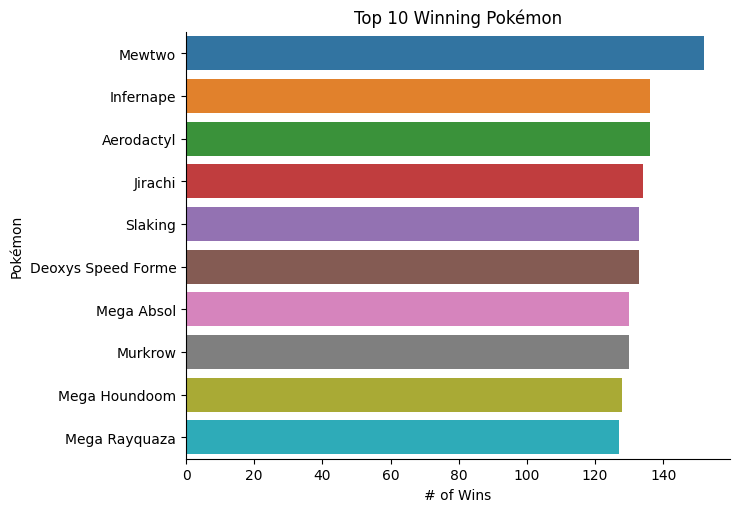

In [12]:
#Pokemons with highest number of wins
top10 = df['Winner'].value_counts().nlargest(10).index

# Filter dataframe to only include top 10 winners
top10_df = df[df['Winner'].isin(top10)]

# Plot with different colors using hue and palette
sns.catplot(
    data=top10_df,
    y='Winner',
    kind='count',
    order=top10,
    aspect=1.5,
    palette='tab10'
).set_axis_labels('# of Wins', 'Pokémon')

plt.title("Top 10 Winning Pokémon")
plt.show()

In [13]:
std_stats.reset_index(inplace=True)
# Top 10 strongest pokemon
pd.merge(
    pokicat, 
    std_stats, 
    on='#'
).sort_values('strength', ascending=False).head(10)


,#,Name,Type 1,Type 2,Generation,Legendary,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,strength
164,165,Mega Mewtwo Y,Psychic,NaN,1,True,0.41,0.78,0.29,1.00,0.48,0.77,3.73
163,164,Mega Mewtwo X,Psychic,Fighting,1,True,0.41,1.00,0.42,0.78,0.38,0.71,3.71
426,427,Mega Rayquaza,Dragon,Flying,3,True,0.41,0.95,0.42,0.92,0.38,0.63,3.71
422,423,Primal Kyogre,Water,NaN,3,True,0.39,0.78,0.38,0.92,0.67,0.49,3.63
424,425,Primal Groudon,Ground,Fire,3,True,0.39,0.95,0.69,0.76,0.33,0.49,3.60
796,797,Mega Diancie,Rock,Fairy,6,True,0.19,0.84,0.47,0.82,0.43,0.60,3.34
552,553,Arceus,Normal,NaN,4,True,0.47,0.62,0.51,0.60,0.48,0.66,3.33
420,421,Mega Latios,Dragon,Psychic,3,True,0.31,0.68,0.42,0.82,0.48,0.60,3.30
409,410,Mega Salamence,Dragon,Flying,3,False,0.37,0.76,0.56,0.60,0.33,0.66,3.27
418,419,Mega Latias,Dragon,Psychic,3,True,0.31,0.51,0.51,0.71,0.62,0.60,3.26


### Data Preparation

In [14]:
pokemon = pd.read_csv("pokemon.csv")

# Fill missing names & types
pokemon = pokemon.fillna({
    'Name':     'Primeape',  
    'Type 2':   'None'       
})

# Convert Legendary to int
pokemon['Legendary'] = pokemon['Legendary'].astype(int)

print(pokemon.columns)

Index(['#', 'Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')


In [15]:
# Feature‐hash the types
from sklearn.feature_extraction import FeatureHasher

h1 = FeatureHasher(n_features=4, input_type='string')
h2 = FeatureHasher(n_features=4, input_type='string')

# wrap each string as a list
t1 = pokemon['Type 1'].apply(lambda s: [s])
t2 = pokemon['Type 2'].apply(lambda s: [s])

d4 = h1.fit_transform(t1).toarray()
d5 = h2.fit_transform(t2).toarray()

d1 = pd.DataFrame(d4, index=pokemon.index, columns=[f'ht1_{i}' for i in range(4)])
d2 = pd.DataFrame(d5, index=pokemon.index, columns=[f'ht2_{i}' for i in range(4)])

In [16]:
# Merge hashed features & drop originals
pokemon = pd.concat([pokemon, d1, d2], axis=1)
pokemon = pokemon.drop(columns=['Type 1','Type 2'])
pokemon.head()


,#,Name,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,ht1_0,ht1_1,ht1_2,ht1_3,ht2_0,ht2_1,ht2_2,ht2_3
0,1,Bulbasaur,45,49,49,65,65,45,1,0,0.00,0.00,-1.00,0.00,1.00,0.00,0.00,0.00
1,2,Ivysaur,60,62,63,80,80,60,1,0,0.00,0.00,-1.00,0.00,1.00,0.00,0.00,0.00
2,3,Venusaur,80,82,83,100,100,80,1,0,0.00,0.00,-1.00,0.00,1.00,0.00,0.00,0.00
3,4,Mega Venusaur,80,100,123,122,120,80,1,0,0.00,0.00,-1.00,0.00,1.00,0.00,0.00,0.00
4,5,Charmander,39,52,43,60,50,65,1,0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,-1.00


In [17]:
# Build the feature array for combats
features_df = pokemon.set_index('#').drop(columns=['Name'])  # numeric features only

data = []
for first_id, second_id, winner_id in battles[['First_pokemon','Second_pokemon','Winner']].itertuples(index=False):
    f1 = features_df.loc[first_id].values
    f2 = features_df.loc[second_id].values
    label = 0 if winner_id == first_id else 1
    data.append(np.concatenate([f1, f2, [label]]))

data = np.array(data)

In [18]:
# Check label distribution
labels = data[:, -1].astype(int)
(unique, counts) = np.unique(labels, return_counts=True)
print(np.vstack((unique,counts)).T, "\n# of total samples:", len(labels))


[[    0 23601]
 [    1 26399]] 
# of total samples: 50000


### Model Processing

In [19]:
X = data[:, :-1].astype(int)
y = data[:, -1].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [20]:
# prepare models
models = []

# Classifiers to use in Voting
boost = xgb.XGBClassifier()
dtc = DecisionTreeClassifier(max_depth=5, criterion='entropy')
lrg = LogisticRegression(solver='liblinear')
vote = VotingClassifier(estimators=[('boost', boost), ('dtc', dtc), ('lrg', lrg)], voting='soft')

models.append(('LRG', LogisticRegression(solver='liblinear', max_iter=250)))
models.append(('KNB', KNeighborsClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RFC', RandomForestClassifier(random_state=0, n_estimators=100)))
models.append(('DTC', DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=5)))
models.append(('SVC', LinearSVC(random_state=0,dual=False)))
models.append(('ADA', AdaBoostClassifier(random_state=0)))

# evaluate each model by average of roc auc 
results_dict = {}
for name, model in models:
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc')
    results_dict[name] = scores.mean()

print(results_dict)

{'LRG': 0.9277699685850742, 'KNB': 0.9336415468595222, 'GNB': 0.8501612094134547, 'RFC': 0.9800190821737518, 'DTC': 0.9537177798448717, 'SVC': 0.9270760411759393, 'ADA': 0.9139907561243984}


In [21]:
# results_dict
sorted(((v,k) for k,v in results_dict.items()), reverse=True)

[(0.9800190821737518, 'RFC'),
 (0.9537177798448717, 'DTC'),
 (0.9336415468595222, 'KNB'),
 (0.9277699685850742, 'LRG'),
 (0.9270760411759393, 'SVC'),
 (0.9139907561243984, 'ADA'),
 (0.8501612094134547, 'GNB')]

### Random Forest

In [22]:
# Fit best model to all of training set
rf = RandomForestClassifier(random_state=0, n_estimators=200)
model = rf.fit(X_train, y_train)
print('Random Forest Classifier \nAccuracy:{0:.3f}'.format(model.score(X_test, y_test)))

Random Forest Classifier 
Accuracy:0.946


In [23]:
print(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

0.9813428889697722


In [29]:
# Save to current working directory
model_save_name = 'pokemon_rf.pt'
torch.save(rf, model_save_name)
print("Model saved to:", os.path.abspath(model_save_name))
loaded_model = torch.load(model_save_name)
print("Loaded model:", loaded_model)


Model saved to: C:\Users\LENOVO\ML\pokemon_rf.pt
Loaded model: RandomForestClassifier(n_estimators=200, random_state=0)


### Predicting the combat result

In [27]:
# Load the saved RandomForest model
rf_loaded = torch.load('pokemon_rf.pt')

# Define the prediction function
def torcall(first_poke: str, second_poke: str):
    feat_cols = [c for c in pokemon.columns if c not in ['#', 'Name']]

    try:
        x = pokemon.loc[pokemon['Name'] == first_poke, feat_cols].values[0]
        y = pokemon.loc[pokemon['Name'] == second_poke, feat_cols].values[0]
    except IndexError:
        print(f"Error: '{first_poke}' or '{second_poke}' not found in Pokémon list.")
        return
   
    sample = np.concatenate([x, y]).reshape(1, -1).astype(int)
    
    pred_flag = rf_loaded.predict(sample)[0]
    winner = first_poke if pred_flag == 0 else second_poke
    
    print(f"\nPredicted winner: {winner}")

# Prompt the user for inputs
first = input("Enter the name of the first Pokémon (attacks first): ")
second = input("Enter the name of the second Pokémon: ")

torcall(first.strip(), second.strip())

Enter the name of the first Pokémon (attacks first): Groudon
Enter the name of the second Pokémon: Charmander

Predicted winner: Groudon
